In [41]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [43]:
# 사용 가능 GPU 확인
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [44]:
# TF 버전
print(tf.__version__)

2.9.1


In [4]:
# 폴더 안에 있는 모든 csv 파일을 읽어서 하나에 DataFrame 으로 만든다
def read_csvs_in_dir(path):
    dfs = []
    for file_name in sorted(os.listdir(path)):
        df = pd.read_csv(path + file_name, parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
        dfs.append(df)
    return pd.concat(dfs)

In [7]:
# 데이터 read
df_train = read_csvs_in_dir('./data/train/')
df_false = read_csvs_in_dir('./data/test/')
df_train.head()

,날짜,시간,대여개수,대기개수,기온,강수량
0,2021-07-01,2022-08-03 00:00:00,2558,23289,0.0,24.0
1,2021-07-01,2022-08-03 01:00:00,2354,23493,0.0,24.0
2,2021-07-01,2022-08-03 02:00:00,1602,24245,0.0,24.0
3,2021-07-01,2022-08-03 03:00:00,1041,24806,0.0,23.0
4,2021-07-01,2022-08-03 04:00:00,836,25011,0.0,23.0


In [15]:
df_train.describe()

,날짜,시간,대여개수,대기개수,기온,강수량
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,183.000000,11.500000,3976.064612,24214.636758,2.243333,10.843573
std,105.372043,6.922582,3279.088212,4201.261344,7.001912,10.735869
min,1.000000,0.000000,23.000000,11130.000000,0.000000,-13.900000
25%,92.000000,5.750000,1235.000000,21491.750000,0.000000,1.000000
50%,183.000000,11.500000,3220.000000,23970.000000,0.000000,11.000000
75%,274.000000,17.250000,5771.500000,26725.000000,0.000000,20.000000
max,365.000000,23.000000,16653.000000,34510.000000,43.900002,35.000000


In [8]:
# 전처리
def preprocess(df):
    df['날짜'] = df['날짜'].dt.dayofyear
    df['시간'] = df['시간'].dt.hour
    return df

df_true = preprocess(df_train)
df_false = preprocess(df_false)
df_false.head()

,날짜,시간,대여개수,대기개수,기온,강수량
0,213,0,7156,17791,1.0,0.0
1,213,1,20438,4509,30.0,0.0
2,213,2,1832,23115,26.0,0.0
3,213,3,6543,18404,26.0,0.0
4,213,4,19106,5841,18.0,5.0


In [9]:
input_true = df_true.values
input_false = df_false.values

timesteps = 24
n_features = input_true.shape[1]

In [10]:
# 3차원화
def temporalize(X, timesteps):
	output_X = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
	return np.squeeze(np.array(output_X))

In [16]:
x_true = temporalize(input_true, timesteps)
x_false = temporalize(input_false, timesteps)
print(x_true.shape)

(8735, 24, 6)


In [12]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [13]:
scaler = StandardScaler().fit(flatten(x_true))

x_true = scale(x_true, scaler)
x_false = scale(x_false, scaler)

In [14]:
x_train, x_valid = train_test_split(x_true, test_size=0.2)

In [25]:
epochs = 1000
batch = 8192
lr = 0.001

In [ ]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

In [26]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid, x_valid))

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.5939 - val_loss: 1.5667
Epoch 2/1000
1/1 [==============================] - 0s 159ms/step - loss: 1.5352 - val_loss: 0.6865
Epoch 3/1000
1/1 [==============================] - 0s 161ms/step - loss: 0.6749 - val_loss: 0.6461
Epoch 4/1000
1/1 [==============================] - 0s 160ms/step - loss: 0.6371 - val_loss: 0.6878
Epoch 5/1000
1/1 [==============================] - 0s 167ms/step - loss: 0.6810 - val_loss: 0.7324
Epoch 6/1000
1/1 [==============================] - 0s 162ms/step - loss: 0.7251 - val_loss: 0.7448
Epoch 7/1000
1/1 [==============================] - 0s 165ms/step - loss: 0.7374 - val_loss: 0.7379
Epoch 8/1000
1/1 [==============================] - 0s 165ms/step - loss: 0.7307 - val_loss: 0.7236
Epoch 9/1000
1/1 [==============================] - 0s 159ms/step - loss: 0.7163 - val_loss: 0.7139
Epoch 10/1000
1/1 [==============================] - 0s 178ms/step - loss: 0.7055 - val_loss: 0.7129
Ep

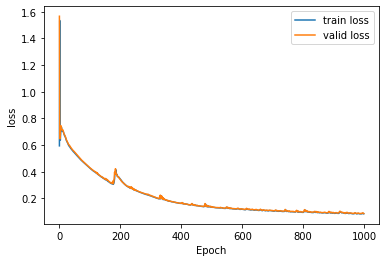

In [27]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

23/23 [==============================] - 0s 16ms/step


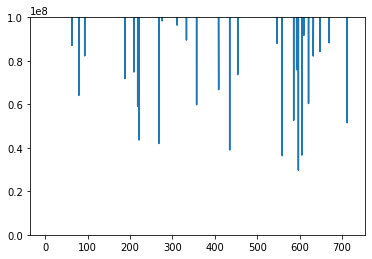

In [39]:
predict_false = lstm_ae.predict(x_false)
mse = np.mean(np.power(flatten(x_false) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse)-1, len(mse)), mse)
plt.ylim([0, 100000000])
plt.show()

55/55 [==============================] - 1s 16ms/step


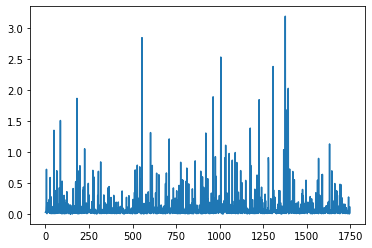

In [29]:
predict_false = lstm_ae.predict(x_valid)
mse = np.mean(np.power(flatten(x_valid) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse)-1, len(mse)), mse)
#plt.ylim([0, 100])
plt.show()

In [30]:
print(x_false.shape)

(719, 24, 6)
